# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import os
import numpy as np

file_path = 'nyc_taxi_data.npy'

if os.path.exists(file_path):
  data = np.load(file_path, allow_pickle=True).item()
  print("File loaded successfully!")
else:
  print(f"Error: File not found at {file_path}")


File loaded successfully!


# Layer

In [ ]:
class Layer:
  def __init__(self, input_dim, output_dim):
      self.input_dim = input_dim
      self.output_dim = output_dim
      self.weights = None
      self.bias = None
      self.input = None


  def initialize_params(self):
      self.weights = np.random.randn(self.input_dim, self.output_dim) * 0.01
      self.bias = np.zeros((1, self.output_dim))

  def forward_pass(self, x):
    raise NotImplementedError

  def backward_pass(self, grad):
    raise NotImplementedError

# Linear Layer

In [ ]:
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        super().__init__(input_dim, output_dim)
        self._init_weights()

    def _init_weights(self):
        """
        Initialize weights and biases using a scaling factor.
        """
        scale = np.sqrt(2 / self.input_dim)
        self.weights = np.random.randn(self.input_dim, self.output_dim) * scale  # Shape: (input_dim, output_dim)
        self.bias = np.zeros((1, self.output_dim))  # Shape: (1, output_dim)

    def forward_pass(self, x):
        """
        Forward pass for the Linear layer.

        Parameters:
        ----------
        x: numpy.ndarray
            Input vector of shape (batch_size, input_dim).

        Returns:
        -------
        output: numpy.ndarray
            Output vector of shape (batch_size, output_dim).
        """
        self.input = x  # Cache input for backward pass
        return x @ self.weights + self.bias  # Shape: (batch_size, output_dim)

    def backward_pass(self, grad_output):
        """
        Backward pass for the Linear layer.

        Parameters:
        ----------
        grad_output: numpy.ndarray
            Gradient received from the next layer, of shape (batch_size, output_dim).

        Returns:
        -------
        grad_input: numpy.ndarray
            Gradient to pass back to the previous layer, of shape (batch_size, input_dim).
        grad_weights: numpy.ndarray
            Gradient for weights, of shape (input_dim, output_dim).
        grad_bias: numpy.ndarray
            Gradient for bias, of shape (1, output_dim).
        """
        # ∂L/∂x = ∂L/∂y @ W.T
        grad_input = grad_output @ self.weights.T  # Shape: (batch_size, input_dim)

        # ∂L/∂W = x.T @ ∂L/∂y
        grad_weights = self.input.T @ grad_output  # Shape: (input_dim, output_dim)

        # ∂L/∂b = summation of ∂L/∂y
        grad_bias = np.sum(grad_output, axis=0, keepdims=True)  # Shape: (1, output_dim)

        self.grad_weights = grad_weights
        self.grad_bias = grad_bias

        return grad_input

# Sigmoid Function

In [ ]:
class Sigmoid(Layer):

  def forward_pass(self, x):
    self.input = x
    return 1/(1 + np.exp(-x))

  def backward_pass(self, grad_output):

    sigmoid = 1/(1 + np.exp(-self.input))
    grad_sigmoid = sigmoid * (1 - sigmoid)

    grad_input = grad_output * grad_sigmoid
    return grad_input

# Tanh

In [ ]:
class Tanh(Layer):

    def forward_pass(self, x):
        self.input = x
        return np.tanh(x)

    def backward_pass(self, grad_output):
        tanh_derivative = 1 - np.tanh(self.input)**2
        grad_input = grad_output * tanh_derivative
        return grad_input

# ReLU

In [ ]:
class RectifiedLinearUnit(Layer):

  def forward_pass(self, x):
    self.input = x
    self.output = np.maximum(0, x)
    return self.output

  def backward_pass(self, grad_output):
    relu_derivative = (self.input > 0).astype(float) #1 if >0, 0 otherwise
    grad_input = grad_output * relu_derivative
    return grad_input

# Binary Cross-Entropy Loss

In [ ]:
class BinaryCrossEntropyLoss:
    def forward_pass(self, y_pred, y_true):
        """
        Compute binary cross-entropy loss.

        Parameters:
        ----------
        y_pred: numpy.ndarray
           Predicted output vector (batch_size, output_dim)
        y_true: numpy.ndarray
           True output vector (batch_size, output_dim)

        Returns:
        -------
        loss: float
           Binary cross-entropy loss
        """
        # Clip predictions to avoid log(0) or log(1)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def backward_pass(self, y_pred, y_true):
        """
        Compute gradient of binary cross-entropy loss.

        Parameters:
        ----------
        y_pred: numpy.ndarray
           Predicted output vector (batch_size, output_dim)
        y_true: numpy.ndarray
           True output vector (batch_size, output_dim)

        Returns:
        -------
        grad: numpy.ndarray
           Gradient of binary cross-entropy loss
        """
        # Clip predictions to avoid division by zero
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

        grad = (y_pred - y_true) / (y_pred * (1 - y_pred))
        return grad

# MSE Loss

In [ ]:
class MSELoss:
    def forward_pass(self, y_pred, y_true):
        """
        Compute Mean Squared Error (MSE) loss.

        Parameters:
        ----------
        y_pred: numpy.ndarray
           Predicted output vector (batch_size, output_dim)
        y_true: numpy.ndarray
           True output vector (batch_size, output_dim)

        Returns:
        -------
        loss: float
           Mean Squared Error loss
        """

        if y_pred.shape[0] != y_true.shape[0]:
          print(f"y_pred.shape: {y_pred.shape} | y_true.shape:{y_true.shape}")
          raise ValueError("MSE could not compute due shape mismatch")

        return np.mean((y_pred - y_true) ** 2)

    def backward_pass(self, y_pred, y_true):
        """
        Compute gradient of Mean Squared Error (MSE) loss.

        Parameters:
        ----------
        y_pred: numpy.ndarray
           Predicted output vector (batch_size, output_dim)
        y_true: numpy.ndarray
           True output vector (batch_size, output_dim)

        Returns:
        -------
        grad: numpy.ndarray
           Gradient of MSE loss
        """

        return 2 * (y_pred - y_true) / y_true.size

# RMSLE Loss

In [ ]:
class RMSLELoss:
    def forward_pass(self, y_true, y_pred):
        """
        Compute Root Mean Squared Logarithmic Error (RMSLE).

        Parameters:
        ----------
        y_true: numpy.ndarray
            True values.
        y_pred: numpy.ndarray
            Predicted values.

        Returns:
        -------
        rmsle: float
            Root Mean Squared Logarithmic Error.
        """
        # Ensure inputs are numpy arrays
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)

        # Clip predictions to avoid log(0)
        y_pred = np.clip(y_pred, 0, None)

        # Compute RMSLE
        log_error = np.log1p(y_true) - np.log1p(y_pred)
        return np.sqrt(np.mean(log_error ** 2))

    def backward_pass(self, y_pred, y_true):
        """
        Compute gradient of Root Mean Squared Logarithmic Error (RMSLE).

        Parameters:
        ----------
        y_pred: numpy.ndarray
            Predicted values.
        y_true: numpy.ndarray
            True values.

        Returns:
        -------
        grad: numpy.ndarray
            Gradient of RMSLE loss.
        """
        # Ensure inputs are numpy arrays
        y_pred = np.asarray(y_pred)
        y_true = np.asarray(y_true)

        # Clip predictions to avoid log(0)
        y_pred = np.clip(y_pred, 0, None)

        # Compute log1p of inputs
        log_true = np.log1p(y_true)
        log_pred = np.log1p(y_pred)

        # Compute the gradient of RMSLE
        n = y_true.size  # Number of elements
        grad = (2 * (log_pred - log_true)) / (n * np.sqrt(np.mean((log_true - log_pred) ** 2)) * (1 / (1 + y_pred)))

        return grad

# Sequential

In [ ]:
class Sequential(Layer):
    def __init__(self, layers):
        self.layers = layers

    def forward_pass(self, x):
        for layer in self.layers:
            x = layer.forward_pass(x)
        return x

    def backward_pass(self, grad_output):
        grad = grad_output
        for layer in reversed(self.layers):
            grad = layer.backward_pass(grad)
        return grad

    def save_model(self, save_path=None):
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            for i, layer in enumerate(self.layers):
                if isinstance(layer, Linear):
                    weights_path = os.path.join(save_path, f"layer_{i}_weights.npy")
                    bias_path = os.path.join(save_path, f"layer_{i}_bias.npy")
                    np.save(weights_path, layer.weights)
                    np.save(bias_path, layer.bias)
        else:
            print("No save path provided. Model parameters not saved.")

    def load_model(self, load_path=None):
        if load_path:
            for i, layer in enumerate(self.layers):
                if isinstance(layer, Linear):
                    weights_path = os.path.join(load_path, f"layer_{i}_weights.npy")
                    bias_path = os.path.join(load_path, f"layer_{i}_bias.npy")
                    layer.weights = np.load(weights_path)
                    layer.bias = np.load(bias_path)
        else:
            print("No load path provided. Model parameters not loaded.")

# Testing

## XOR Test

In [ ]:
# Testing XOR Data
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

input_dim = 2
hidden_dim = 4
output_dim = 1

linear1 = Linear(input_dim, hidden_dim)
linear2 = Linear(hidden_dim, output_dim)

# Hidden layers
sigmoid1 = Sigmoid(hidden_dim, hidden_dim)
tanh1 = Tanh(hidden_dim, hidden_dim)
relu1 = RectifiedLinearUnit(hidden_dim, hidden_dim)

# Outside layers
sigmoid2 = Sigmoid(output_dim, output_dim)
tanh2 = Tanh(output_dim, output_dim)
relu2 = RectifiedLinearUnit(output_dim, output_dim)

linear1.initialize_params()
linear2.initialize_params()

# Design model
model = Sequential([linear1, relu1, linear2, sigmoid2])

bce_loss = BinaryCrossEntropyLoss()

# Training parameters
epochs = 20000
lr = 0.01

# Training loop
# -------------
print("Training for XOR:")
for epoch in range(epochs):
    epoch_loss = 0

    for i in range(X.shape[0]):
        x = X[i].reshape(1, -1)
        y_true = y[i].reshape(1, -1)

        # Forward pass
        y_pred = model.forward_pass(x)
        loss = bce_loss.forward_pass(y_pred, y_true)

        # Backward pass
        grad_y_pred = bce_loss.backward_pass(y_pred, y_true)
        grad_input = model.backward_pass(grad_y_pred)

        # Update weights and biases (Gradient Descent)
        for layer in model.layers:
            if isinstance(layer, Linear):
                layer.weights = layer.weights -lr*layer.grad_weights
                layer.bias = layer.bias - lr * layer.grad_bias

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")
print(f"Final epoch: {epoch}, Final Loss: {loss}")

Training for XOR:
Epoch: 0, Loss: 0.6955779381258763
Epoch: 1000, Loss: 0.6905710989292064
Epoch: 2000, Loss: 0.2625359702271389
Epoch: 3000, Loss: 0.024617778829737043
Epoch: 4000, Loss: 0.009652136939420124
Epoch: 5000, Loss: 0.00564827039466283
Epoch: 6000, Loss: 0.003890157786472382
Epoch: 7000, Loss: 0.002925782592573935
Epoch: 8000, Loss: 0.002324769583803098
Epoch: 9000, Loss: 0.0019171896941865623
Epoch: 10000, Loss: 0.0016239889204294642
Epoch: 11000, Loss: 0.0014051205022737668
Epoch: 12000, Loss: 0.0012343470971343318
Epoch: 13000, Loss: 0.0010988211450542547
Epoch: 14000, Loss: 0.00098880720470601
Epoch: 15000, Loss: 0.0008972474376972183
Epoch: 16000, Loss: 0.0008124754546593794
Epoch: 17000, Loss: 0.0007387919157385203
Epoch: 18000, Loss: 0.0006766783370865796
Epoch: 19000, Loss: 0.0006230703176557897
Final epoch: 19999, Final Loss: 0.0005768085354982319


## XOR Evaluation

To fine-tune this model, I played with parameters like epochs, increasing hidden dimensions from 2 to 4, and experimented with the model design. I had decent results after using ReLU as the hidden layer and sigmoid as the output layer. I also experimented using tangent, but could not get a loss below 30. Overall, I was able to have my model guess correct values and solve the XOR problem.

In [ ]:
# Load XOR_solved [ optional ]
# model.load_model(load_path="XOR_solved")

In [ ]:
# Evaluate XOR predictions
print("Evaluating XOR:")
for i in range(len(X)):
    x = X[i].reshape(1, -1)
    y_true = y[i].reshape(1, -1)
    y_pred = model.forward_pass(x)

    # Threshold predictions
    y_pred_binary = (y_pred >= 0.5).astype(int)

    print(f"Input: {x}, Predicted: {y_pred_binary}, True: {y_true}")

Evaluating XOR:
Input: [[0 0]], Predicted: [[0]], True: [[0]]
Input: [[0 1]], Predicted: [[1]], True: [[1]]
Input: [[1 0]], Predicted: [[1]], True: [[1]]
Input: [[1 1]], Predicted: [[0]], True: [[0]]


In [ ]:
# Save model [ optional ]
model.save_model(save_path="XOR_solved")

# Trip Duration Model

## Dataset Preprocessing

In [ ]:
X_train = data['X_train']
X_test  = data['X_test']
y_train = data['y_train']
y_test  = data['y_test']

# Get validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# 1. Convert datetime columns to datetime objects:
X_train['pickup_datetime'] = pd.to_datetime(X_train['pickup_datetime'])
X_test['pickup_datetime']  = pd.to_datetime(X_test['pickup_datetime'])
X_val['pickup_datetime']   = pd.to_datetime(X_val['pickup_datetime'])

X_train['dropoff_datetime'] = pd.to_datetime(X_train['dropoff_datetime'])
X_test['dropoff_datetime']  = pd.to_datetime(X_test['dropoff_datetime'])
X_val['dropoff_datetime']   = pd.to_datetime(X_val['dropoff_datetime'])

# 2. Convert 'store_and_fwd_flag' to numerical:
X_train['store_and_fwd_flag'] = X_train['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
X_test['store_and_fwd_flag']  = X_test['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
X_val['store_and_fwd_flag']   = X_val['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

# 3. Feature extraction:
X_train['trip_duration_seconds'] = (X_train['dropoff_datetime'] - X_train['pickup_datetime']).dt.total_seconds()
X_test['trip_duration_seconds']  = (X_test['dropoff_datetime'] - X_test['pickup_datetime']).dt.total_seconds()
X_val['trip_duration_seconds']   = (X_val['dropoff_datetime'] - X_val['pickup_datetime']).dt.total_seconds()

X_val['pickup_hour']        = X_val['pickup_datetime'].dt.hour
X_val['pickup_day_of_week'] = X_val['pickup_datetime'].dt.dayofweek
X_val['pickup_month']       = X_val['pickup_datetime'].dt.month

X_train['pickup_hour']        = X_train['pickup_datetime'].dt.hour
X_train['pickup_day_of_week'] = X_train['pickup_datetime'].dt.dayofweek
X_train['pickup_month']       = X_train['pickup_datetime'].dt.month

X_test['pickup_hour']        = X_test['pickup_datetime'].dt.hour
X_test['pickup_day_of_week'] = X_test['pickup_datetime'].dt.dayofweek
X_test['pickup_month']       = X_test['pickup_datetime'].dt.month

X_val['manhattan_distance']   = abs(X_val['pickup_longitude'] - X_val['dropoff_longitude']) + abs(X_val['pickup_latitude'] - X_val['dropoff_latitude'])
X_train['manhattan_distance'] = abs(X_train['pickup_longitude'] - X_train['dropoff_longitude']) + abs(X_train['pickup_latitude'] - X_train['dropoff_latitude'])
X_test['manhattan_distance']  = abs(X_test['pickup_longitude'] - X_test['dropoff_longitude']) + abs(X_test['pickup_latitude'] - X_test['dropoff_latitude'])

# 4. Feature Scaling:
# Standardization from StandardScalar (z score): z = (x - μ) / σ
numerical_features = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration_seconds',   'pickup_hour', 'pickup_day_of_week', 'pickup_month', 'manhattan_distance']
X3_features        = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_hour']

scaler= StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features]  = scaler.transform(X_test[numerical_features])
X_val[numerical_features]   = scaler.transform(X_val[numerical_features])

# 5. Drop unnecessary columns:
X_val   = X_val.drop(['id','vendor_id', 'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime'], axis=1)
X_train = X_train.drop(['id','vendor_id','store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime'], axis=1)
X_test  = X_test.drop(['id','vendor_id','store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime'], axis=1)

# 6. Convert DataFrames to NumPy arrays
X_train = X_train.values
X_val   = X_val.values
X_test  = X_test.values
y_train = y_train.values
y_val   = y_val.values
y_test  = y_test.values

y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_val   = scaler.transform(y_val.reshape(-1, 1))
y_test  = scaler.transform(y_test.reshape(-1, 1))

# Testing dataframes
# print(X_train.head())
# print(X_test.head())

In [ ]:
# Use same data for model 2
cached_X_train = X_train.copy()
cached_y_train = y_train.copy()
cached_X_test  = X_test.copy()
cached_y_test  = y_test.copy()
cached_X_val   = X_val.copy()
cached_y_val   = y_val.copy()

In [ ]:
# Copy shared data for model 3
X3_train = X_train[:, [numerical_features.index(f) for f in X3_features]]
X3_val   = X_val[:, [numerical_features.index(f) for f in X3_features]]
X3_test  = X_test[:, [numerical_features.index(f) for f in X3_features]]
y3_train = y_train.copy()
y3_val   = y_val.copy()
y3_test  = y_test.copy()

# Model 1

Epoch: 0, Training Loss: 0.09129126917483175, Validation Loss: 0.017925382069956565
Early stopping at epoch 4 with best validation loss: 0.017925382069956565
Test Loss (MSE): 0.017906973214488774
Test Loss (RMSLE): 0.07883972660894283


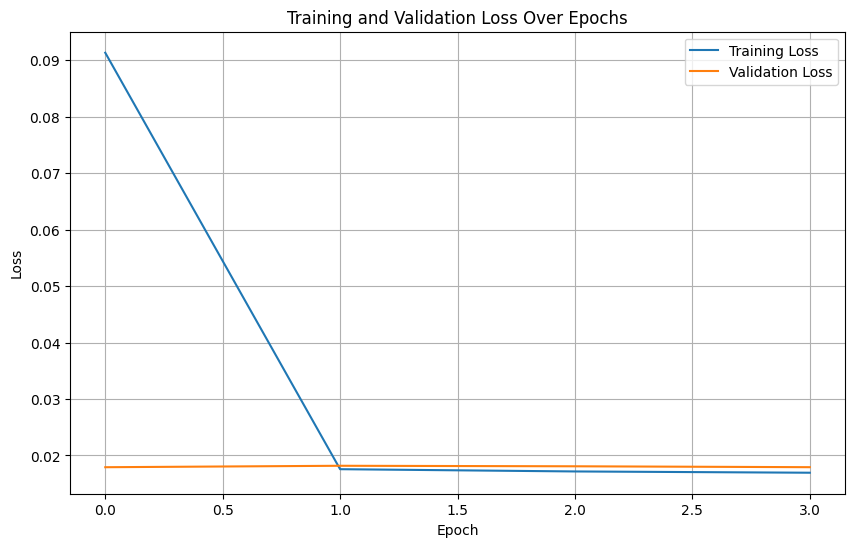

In [ ]:
# Reusing data from previous model
X_train = cached_X_train
y_train = cached_y_train
X_test = cached_X_test
y_test = cached_y_test
X_val = cached_X_val
y_val = cached_y_val

# Define model dimensions
input_dim = X_train.shape[1]
hidden_dim = 16
output_dim = 1

linear1 = Linear(input_dim, hidden_dim)
relu1 = RectifiedLinearUnit(hidden_dim, hidden_dim)

linear2 = Linear(hidden_dim, output_dim)
relu2 = RectifiedLinearUnit(output_dim, output_dim)

# Initialize model
model = Sequential([linear1, relu1, linear2, relu2])

mse_loss = MSELoss()
rmsle_loss = RMSLELoss()

# Training parameters
epochs = 140
lr = 0.0001
batch_size = 32

# Early stopping parameters
patience = 3
epoch_no_improvement = 0
best_val_loss = float('inf')

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        x = X_train[i:i + batch_size]
        y_true = y_train[i:i + batch_size]

        # Forward Pass
        y_pred = model.forward_pass(x)
        loss = mse_loss.forward_pass(y_pred, y_true)

        # Backward pass
        grad_y_pred = mse_loss.backward_pass(y_pred, y_true)
        model.backward_pass(grad_y_pred)

        # Update weights and biases (Gradient Descent)
        for layer in model.layers:
            if isinstance(layer, Linear):
                layer.weights -= lr * layer.grad_weights
                layer.bias -= lr * layer.grad_bias

        epoch_loss += loss

    epoch_loss /= (len(X_train) // batch_size)
    train_losses.append(epoch_loss)  # Store training loss (plotting)

    # Validation loss
    val_pred = model.forward_pass(X_val)
    val_loss = mse_loss.forward_pass(val_pred, y_val)
    val_losses.append(val_loss)  # Store validation loss (plotting)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epoch_no_improvement = 0
    else:
        epoch_no_improvement += 1

    if epoch_no_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1} with best validation loss: {best_val_loss}")
        break

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}")


# Make predictions on the test set
test_pred = model.forward_pass(X_test)

# Compute test loss (MSE)
test_loss = mse_loss.forward_pass(test_pred, y_test)
print(f"Test Loss (MSE): {test_loss}")

# Root Mean Squared Logarithmic Error (RMSLE)
test_rmsle = rmsle_loss.forward_pass(test_pred, y_test)
print(f"Test Loss (RMSLE): {test_rmsle}")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model1_total_loss_mse = test_loss
model.save_model(save_path="model1")

# Model \#2

In [ ]:
# Reusing data from previous model
X_train = cached_X_train
y_train = cached_y_train
X_test = cached_X_test
y_test = cached_y_test
X_val = cached_X_val
y_val = cached_y_val

Epoch: 0, Training Loss: 1.000125353047093, Validation Loss: 0.3186106648004981
Epoch: 10, Training Loss: 1.0000152106639315, Validation Loss: 0.3186000920373595
Epoch: 20, Training Loss: 1.0000122197702503, Validation Loss: 0.31859773802701585
Epoch: 30, Training Loss: 1.000006983263791, Validation Loss: 0.31859134171114567
Epoch: 40, Training Loss: 0.9999932239864303, Validation Loss: 0.3185733119018126
Epoch: 50, Training Loss: 0.9999134334315759, Validation Loss: 0.318485124269989
Early stopping at epoch 57 with best validation loss: 0.3147370788929519
Test Loss (MSE): 0.34789280600748623
Test Loss (RMSLE): 0.1337967526683928


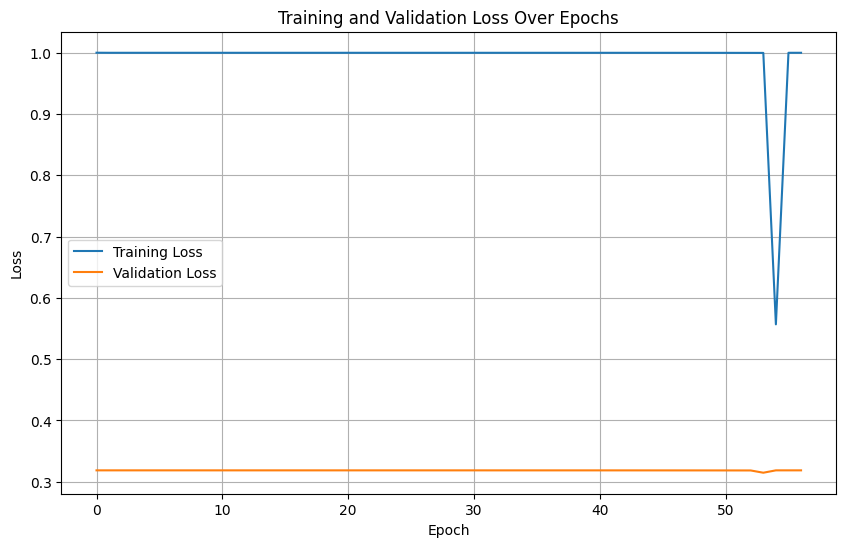

In [ ]:
# Define model dimensions
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 1

linear1 = Linear(input_dim, hidden_dim)
relu1 = RectifiedLinearUnit(hidden_dim, hidden_dim)

linear2 = Linear(hidden_dim, output_dim)
relu2 = RectifiedLinearUnit(output_dim, output_dim)

# Initialize model
model = Sequential([linear1, relu1, relu2, linear2, relu2])

mse_loss = MSELoss()

# Training parameters
epochs = 140
lr = 0.001
batch_size = 32

# Early stopping parameters
patience = 3
epoch_no_improvement = 0
best_val_loss = float('inf')

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        x = X_train[i:i + batch_size]
        y_true = y_train[i:i + batch_size]

        # Forward Pass
        y_pred = model.forward_pass(x)
        loss = mse_loss.forward_pass(y_pred, y_true)

        # Backward pass
        grad_y_pred = mse_loss.backward_pass(y_pred, y_true)
        model.backward_pass(grad_y_pred)

        # Update weights and biases (Gradient Descent)
        for layer in model.layers:
            if isinstance(layer, Linear):
                layer.weights -= lr * layer.grad_weights
                layer.bias -= lr * layer.grad_bias

        epoch_loss += loss

    epoch_loss /= (len(X_train) // batch_size)
    train_losses.append(epoch_loss)  # Store training loss

    # Validation loss
    val_pred = model.forward_pass(X_val)
    val_loss = mse_loss.forward_pass(val_pred, y_val)
    val_losses.append(val_loss)  # Store validation loss

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epoch_no_improvement = 0
    else:
        epoch_no_improvement += 1

    if epoch_no_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1} with best validation loss: {best_val_loss}")
        break

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}")

# Make predictions on the test set
test_pred = model.forward_pass(X_test)

# Compute test loss (MSE)
test_loss = mse_loss.forward_pass(test_pred, y_test)
print(f"Test Loss (MSE): {test_loss}")

# Root Mean Squared Logarithmic Error (RMSLE)
test_rmsle = rmsle_loss.forward_pass(test_pred, y_test)
print(f"Test Loss (RMSLE): {test_rmsle}")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model2_total_loss_mse = test_loss
model.save_model(save_path="model2")

# Model \#3

In [ ]:
# Use similar features from model 1
X_train = X3_train
y_train = y3_train
X_test  = X3_test
y_test  = y3_test
X_val   = X3_val
y_val   = y3_val

Epoch: 0, Training Loss: 1.0113005983816343, Validation Loss: 0.31707305618719117
Epoch: 10, Training Loss: 0.9980572214810146, Validation Loss: 0.31621030778326276
Epoch: 20, Training Loss: 0.9978608291743746, Validation Loss: 0.3159949820722302
Epoch: 30, Training Loss: 0.9977327940165319, Validation Loss: 0.3158647320103147
Epoch: 40, Training Loss: 0.9976453923092451, Validation Loss: 0.31578183341757743
Epoch: 50, Training Loss: 0.9975728065469085, Validation Loss: 0.3157172642580544
Epoch: 60, Training Loss: 0.9974972349888325, Validation Loss: 0.3156470624294876
Epoch: 70, Training Loss: 0.9974175332115405, Validation Loss: 0.3155683932028728
Epoch: 80, Training Loss: 0.9973253630794525, Validation Loss: 0.3154826981619792
Epoch: 90, Training Loss: 0.997214065311523, Validation Loss: 0.3153769776051857
Epoch: 100, Training Loss: 0.9960946483103745, Validation Loss: 0.3150584181714708
Epoch: 110, Training Loss: 0.9956241264286682, Validation Loss: 0.31469766541704747
Epoch: 120, 

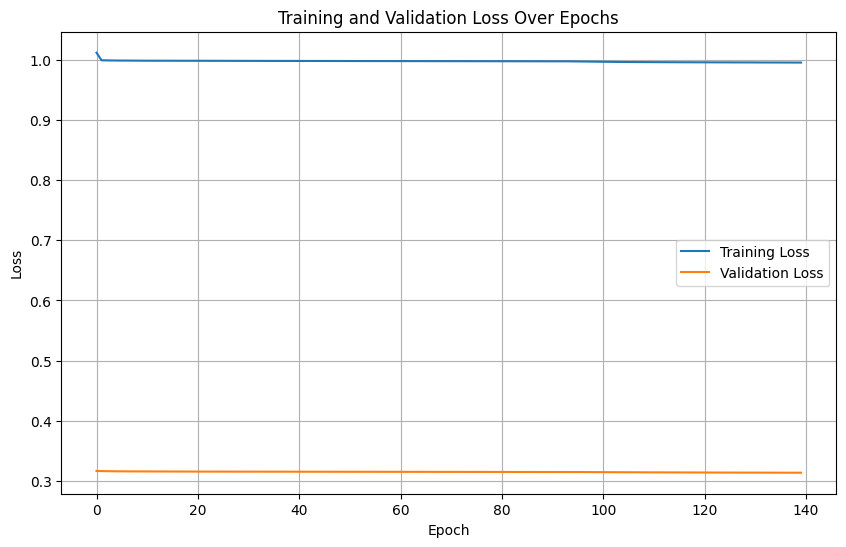

In [ ]:
# Define model dimensions
input_dim = X_train.shape[1]
hidden_dim = 8
output_dim = 1

linear1 = Linear(input_dim, hidden_dim)
relu1 = RectifiedLinearUnit(hidden_dim, hidden_dim)
tanh1 = Tanh(hidden_dim, hidden_dim)

linear2 = Linear(hidden_dim, output_dim)
relu2 = RectifiedLinearUnit(output_dim, output_dim)

# Initialize model
model = Sequential([linear1, tanh1, linear2, relu2])

mse_loss = MSELoss()

# Training parameters
epochs = 140
lr = 0.0001
batch_size = 32

# Early stopping parameters
patience = 3
epoch_no_improvement = 0
best_val_loss = float('inf')

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        x = X_train[i:i + batch_size]
        y_true = y_train[i:i + batch_size]

        # Forward Pass
        y_pred = model.forward_pass(x)
        loss = mse_loss.forward_pass(y_pred, y_true)

        # Backward pass
        grad_y_pred = mse_loss.backward_pass(y_pred, y_true)
        model.backward_pass(grad_y_pred)

        # Update weights and biases (Gradient Descent)
        for layer in model.layers:
            if isinstance(layer, Linear):
                layer.weights -= lr * layer.grad_weights
                layer.bias -= lr * layer.grad_bias

        epoch_loss += loss

    epoch_loss /= (len(X_train) // batch_size)
    train_losses.append(epoch_loss)  # Store training loss

    # Validation loss
    val_pred = model.forward_pass(X_val)
    val_loss = mse_loss.forward_pass(val_pred, y_val)
    val_losses.append(val_loss)  # Store validation loss

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epoch_no_improvement = 0
    else:
        epoch_no_improvement += 1

    if epoch_no_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1} with best validation loss: {best_val_loss}")
        break

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}")

test_pred = model.forward_pass(X_test)

# Compute test loss (MSE)
test_loss = mse_loss.forward_pass(test_pred, y_test)
print(f"Test Loss (MSE): {test_loss}")

# Root Mean Squared Logarithmic Error (RMSLE)
test_rmsle = rmsle_loss.forward_pass(test_pred, y_test)
print(f"Test Loss (RMSLE): {test_rmsle}")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model3_total_loss_mse = test_loss
model.save_model(save_path="model3")

# 3 Model Comparison

---



In [ ]:
print(f"Final Results\n--------------------------------\nModel 1 MSE: {model1_total_loss_mse} \nModel 2 MSE {model2_total_loss_mse} \nModel 2 MSE {model3_total_loss_mse}")

Final Results
--------------------------------
Model 1 MSE: 0.018807124332440927 
Model 2 MSE 0.34789281973997616 
Model 2 MSE 0.3436075497776558
